In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from mpl_toolkits import mplot3d
import pandas as pd
#from sklearn.decomposition import PCA

## Topic 1 - PCA Introduction
### 1) Get the data

originally this script was used for my phD thesis with the data set: file = "/home/isabel/Documents/Doktorarbeit_Mai2022/P5_Ngo_fromSciebo/RNA/2022March_Run4/1_Analysis1_naiv/2a_PreAnalysis_woMM/rlogMat.csv" 

-- interesting read: https://www.nxn.se/valent/2017/6/12/how-to-read-pca-plots


In [2]:
file = "/home/isabel/Documents/postDoc_Amsterdam/1_EvolWormJourney/1_Genomics/2_EvolGenomics/2_Metagenomics/3_PCA/KraBracken_DBplusPf_042024_0minFrac_genus_FromPY.csv"

#how many columns from the left to ignore?
text_columns = 4

dat_temp = pd.read_csv(file)
dat_wrong = dat_temp.to_numpy()[:,text_columns+1:]

# IMPORTANT: we have to transpose the data!
dat = dat_wrong.transpose()

# this are the row naes of the transposed data
geneNames = np.array(list(dat_temp.columns))[text_columns+1:]

# these are the column names of the transposed data!
conditions = dat_temp["name_short"]
institution = dat_temp["institution"]
treatment = dat_temp["treatment"]
replicate = dat_temp["replicate"]
week = dat_temp["week"]

#exc_List = []; #[55 ,565 , 985 ,1653 ,1654 ,1384,  830 ,1059 , 948 , 831, 1498 ,1191 ,1053, 1482]

#color_cond = np.array(9*["k"]+4*["r"])
#marker_cond=(4*["X"]+9*["o"])
color_cond = np.array(13*["k"]+ 24 * ["gray"]+ 9* ["yellow"]+ 4* ["blue"]+ 35* ["red"] + 8*["purple"])# for institutions
marker_treatment = (9*["d"]+ 4* ["o"] + 10*["^"] + 8*["<"] + 15*["d"]+ 3*["s"] + 16*["d"] + 10*["P"] + 10*["X"] + 6*["d"] +2* ["p"])# for institutions
marker_week = (4*["d"]+ 9* ["o"] + 5*["d"]+ 5* ["o"] + 4*["d"]+ 4* ["o"] + 3*["d"]+ 3* ["o"] + 4*["d"]+ 5* ["o"] + 9*["P"] + 5*["d"]+ 5* ["o"] + 5*["P"] + 5*["o"]+ 5*["P"] + 5*["o"] + 3*["d"]+ 5* ["o"])# for institutions
# for institutions and treatements
exc_List = []

dat.shape
type(dat)

numpy.ndarray

In [3]:
# exclude the entries in exc_List!
dat_filt       = dat.copy()
geneNames_filt = geneNames.copy()

dat_filt       = np.array([row for i, row in enumerate(dat_filt) if i not in exc_List]) 
geneNames_filt = np.array([row for i, row in enumerate(geneNames_filt) if i not in exc_List]) 

dat_filt

array([[0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
       [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
       [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
       ...,
       [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
       [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
       [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0]], dtype=object)

In [4]:
# plot a heatmp from the matrix

#a = sns.heatmap(dat, interpolation='nearest')
#plt.show()

### 2) Subtract the mean

[(5, 10), (1, 8)]

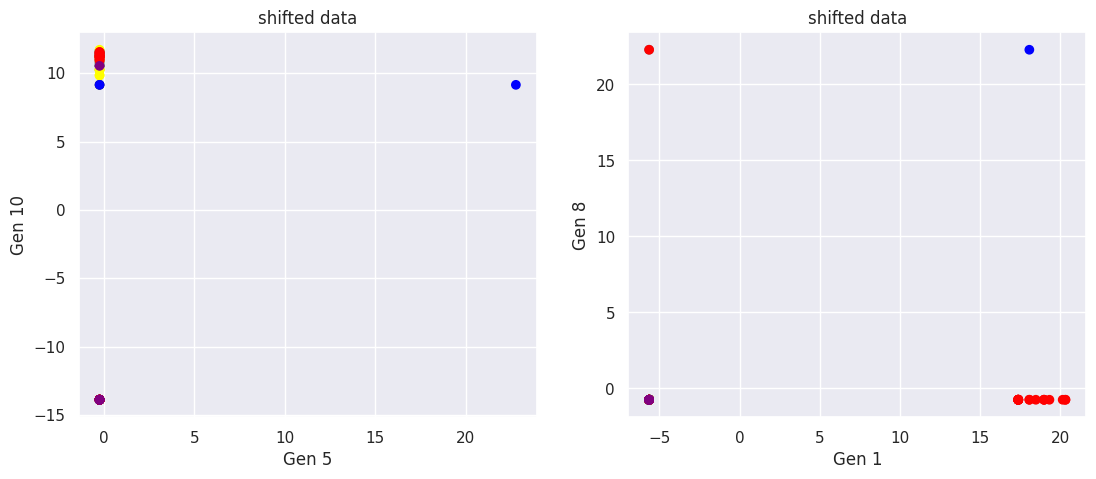

In [5]:
# convert data tomatrix
mat_raw = dat_filt.astype(float)
mat_raw = np.log(mat_raw + 1e-15)


mean_raw = np.mean(mat_raw,axis = 1)

shifted_raw = (mat_raw.transpose() - mean_raw).transpose()

# Show two pairs of genes together, pick them here:
show_genes = [(5, 10), (1, 8)]
fig, axes = plt.subplots(1, 2, figsize=(13, 5))
for pair, ax in zip(show_genes, axes):
    # Show first pair of genes, the `*` unpacks the two rows selected by `pair`
    ax.scatter(*shifted_raw[pair,:],color=color_cond)
    ax.set_title('shifted data')
    ax.set_xlabel(f'Gen {pair[0]}')
    ax.set_ylabel(f'Gen {pair[1]}')

show_genes

### 3) Calculate the covariance matrix

In [6]:
# GET the Covariance matrix, because this is the important matrix!!! 
# it is symmetric
cov_mat = np.cov(shifted_raw)
cov_mat.shape

(1293, 1293)

### 4) calculate the eigenvalues and eigenvectors of the covariance matrix

In [7]:
# get the eigenvector + wert of the 
eigen_val,  eigen_vec = np.linalg.eigh(cov_mat)
#print (eigen_val);
#print (eigen_vec);

# comment: the first eigenvector is found in the first colums belonging to first eigenwert and so on ... 


In [8]:
# these are the eigenvalues from highest
print(eigen_val[-6:])

[ 2218.67667124  2710.01641517  3829.96644196  4293.05973719
 14663.56633814 15462.32100064]


In [9]:
idx_sort = np.flip(np.argsort(eigen_val));

# we are only interested in the first XX components
# set how many u are interested in:
maxComponents = len(idx_sort);

idx_sort_OI = idx_sort[0:maxComponents];

# create the feature matrix T_B
TB = np.zeros((len(idx_sort_OI),eigen_vec.shape[1]))
for i in range(0,len(idx_sort_OI)):
    TB[i,:] = eigen_vec[:,idx_sort_OI[i]]


### 5) Derive the new data set :)

Now we have the eigenvectors and eigenwerte to the covariance matrix. We have also sorted them according to highest eigenwert, in order of descending magnitude ($T_B$).


For each condition $i$ we have expression data for all the genes, collected in the column vectors $\overrightarrow{\text{Dat}_i}$. With the eigenvectors collected in a matrix $T_B$ (each eigenvector is one row), we can transform the vectors to the new basis by multiplying vector to matrix: 

$$ \overrightarrow{\text{Dat}}_{\text{i}}' = \begin{pmatrix} ...\vec{e_1}... \\ ...\vec{e_2}... \\ \vdots \\ ...\vec{e_n}... \end{pmatrix} \cdot 
\overrightarrow{\text{Dat}}_{\text{i}} = T_B \cdot \overrightarrow{\text{Dat}}_{\text{i}} $$

This wouldn't really reduce our data set, but we know, that most of the information is contained in a few principal components. So what we do is, we reduce the transformation matrix $T_B$ and cut away all the rows that contain small components. Let's say, we only keep 4 rows. 

$$ \overrightarrow{\text{Dat}}_{\text{i}}' = \begin{pmatrix} ...\vec{e_1}... \\ ...\vec{e_2}... \\ ...\vec{e_3}...  \\ ...\vec{e_4}... \end{pmatrix} \cdot 
\overrightarrow{\text{Dat}}_{\text{i}} $$

In [10]:
data_final = np.dot(TB,shifted_raw)
data_final.shape;

In [11]:
# now get the % of variance that this covers :)
# Iterate over the first 6 variances, unless maxComponents was smaller, then stop earlier of course.
for i in range(min([6, maxComponents])):
    print(f"Variance along axis {i+1}: {np.round(np.var(data_final[i]), 8):11.8f}")
    #                           ^^^^^ depends on how we count             ^^^^^^ Formatting string, not crucial
    
collect_var = np.zeros(maxComponents)
# Elegant way of evaluating the variance, numpy takes an `axis` argument for many functions, 
# which indicates along which axis the function is executed. Here we want `axis=1`, i.e. the second axis.
collect_var = np.var(data_final, axis=1) * len(data_final[0]) / (len(data_final[0]) - 1) 
    
# I think the fraction of the whole variance can be calculated like this ...
frac_of_var  = collect_var / np.sum(collect_var) 
frac_of_var

Variance along axis 1: 15296.05948450
Variance along axis 2: 14505.89358181
Variance along axis 3: 4246.89780453
Variance along axis 4: 3788.78400710
Variance along axis 5: 2680.87645372
Variance along axis 6: 2194.81993284


array([2.20721898e-01, 2.09319817e-01, 6.12826686e-02, ...,
       1.12264226e-31, 5.62377856e-32, 5.45374002e-32])

[ -70.25124646   16.33517486  -41.64463106  -14.62403968  -31.19304282
  287.15280011  -11.23527285   -4.94135461   34.44906661  -27.41299584
   51.41460265  -57.39301795   57.23927508  -18.498467      1.52415795
   -0.74013985   -0.54751695    3.12300052  -37.90990296  -15.70083583
    4.39815961   -8.866072    -18.11944918  -14.8621921    -4.47323103
    3.33249765   -5.59829605  -51.27208064  -74.03534009   11.58698423
    7.19596422  -71.82008525  -40.03469828  -71.92410923  -57.95956091
  -14.94116027  -49.51482352 -110.8055241  -112.22788114 -113.64424487
 -112.5483771   -64.81956607  -71.71840683  -58.98004545  -67.1254283
  -30.88570171  -95.79542513  -59.43671107 -128.17621158  154.18064557
 -123.79018183  -94.04351178 -118.44334277 -134.07736523  226.5844079
 -138.04466969 -131.72222272 -134.87604928 -130.68109451 -133.30016001
 -120.61550983  216.41850421  200.60480742  198.30786264  233.27407806
   16.7147147    21.32709894  -19.09177963  -63.95575657  -40.20978867
  295.41

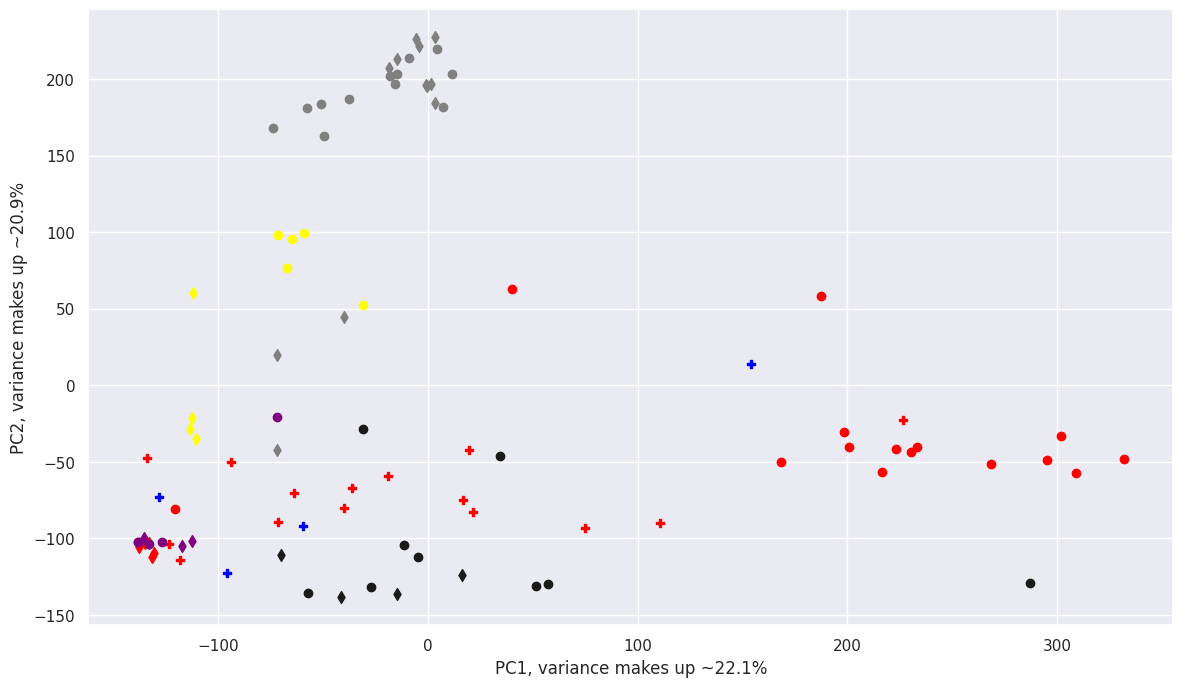

In [12]:
# plot the 2 principle components

def plot_two_PCs(data, pc_indices, variance_fractions):
    i, j = pc_indices
    fig, ax = plt.subplots(1, 1, figsize=(14, 8))
    plt.scatter(data_final[i,:], data_final[j,:], color=color_cond)
    plt.xlabel(f"PC{i+1}, variance makes up ~{np.round(variance_fractions[i]*100, 1)}%")
    plt.ylabel(f"PC{j+1}, variance makes up ~{np.round(variance_fractions[j]*100, 1)}%");
    
#plot_two_PCs(data_final, [0, 1], frac_of_var)

# because I want the markers, I will do it by hand ..
comp1 = 0
comp2 = 1
fig, ax = plt.subplots(1, 1, figsize=(14, 8))
for d in range(len(color_cond)):
    plt.scatter(data_final[comp1,d], data_final[comp2,d], color=color_cond[d], marker=marker_week[d])


plt.xlabel(f"PC{comp1+1}, variance makes up ~{np.round(frac_of_var[comp1]*100, 1)}%")
plt.ylabel(f"PC{comp2+1}, variance makes up ~{np.round(frac_of_var[comp2]*100, 1)}%");
    



#plt.xlim([-0.7,0.6])
#plt.ylim([-0.9,0.3])

#plt.xlim([-0.75,0.5])
#plt.ylim([-0.4,0.6])

# Save as a SVG and PNG
#plt.savefig('/home/isabel/Documents/Doktorarbeit_Mai2022/P5_Ngo_fromSciebo/RNA/2022March_Run4/1_Analysis1_naiv/2a_PreAnalysis_woMM/plot_from_python/PCA_20221109.svg')
d=0
print(data_final[0,:])
print(data_final[1,:])


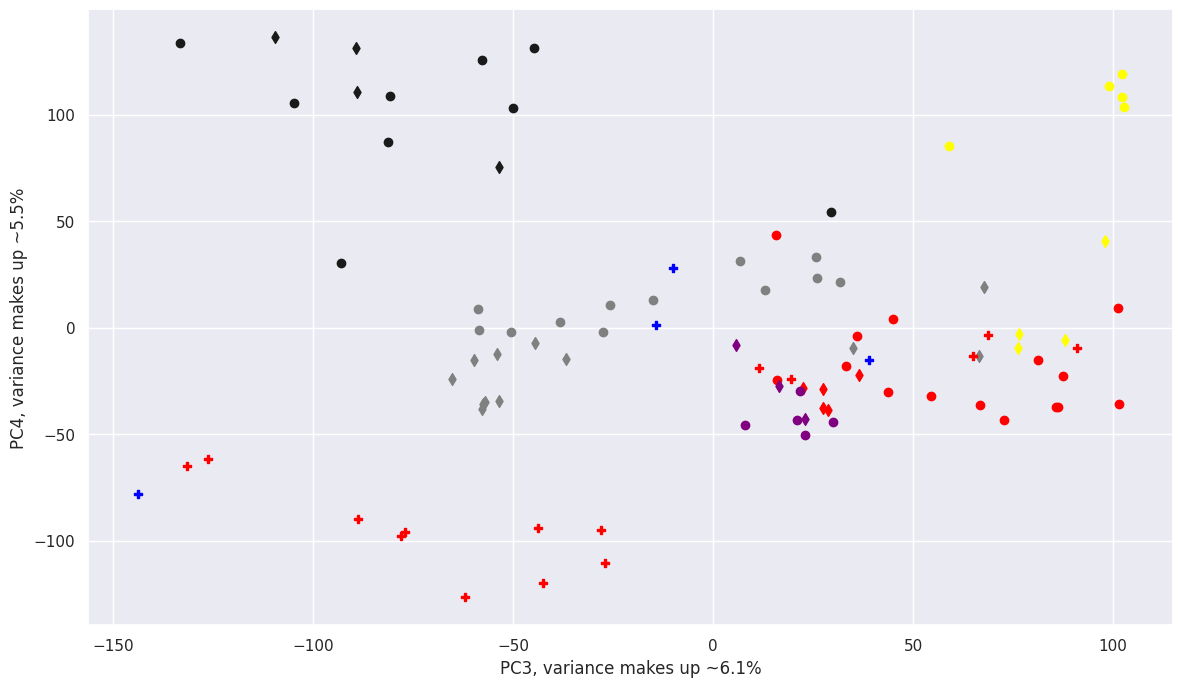

In [21]:
# plot the 3rd and 4th principle components
# because I want the markers, I will do it by hand ..
comp1 = 2
comp2 = 3
fig, ax = plt.subplots(1, 1, figsize=(14, 8))
for d in range(len(color_cond)):
    plt.scatter(data_final[comp1,d], data_final[comp2,d], color=color_cond[d], marker=marker_week[d])


plt.xlabel(f"PC{comp1+1}, variance makes up ~{np.round(frac_of_var[comp1]*100, 1)}%")
plt.ylabel(f"PC{comp2+1}, variance makes up ~{np.round(frac_of_var[comp2]*100, 1)}%");

### 6) Look at the components of the eigenvectors:
- Why should we want to do this?
    - naja, here: $$ \overrightarrow{\text{Dat}}_{\text{i}}' = \begin{pmatrix} ...\vec{e_1}... \\ ...\vec{e_2}... \\ ...\vec{e_3}...  \\ ...\vec{e_4}... \end{pmatrix} \cdot 
\overrightarrow{\text{Dat}}_{\text{i}} $$
    - if one of the "important" eigenvectors has a big component, this means that the impact of the according gene on the component in the new basis will be high


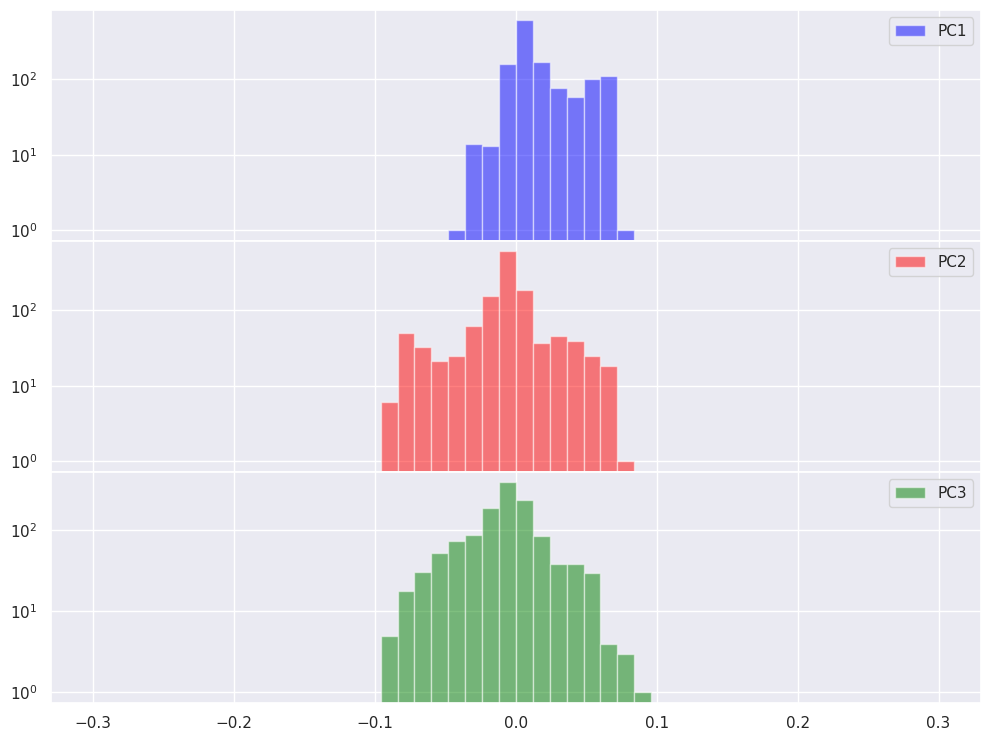

In [14]:

fig, axs = plt.subplots(3, 1, sharex=True, gridspec_kw={"hspace": 0}, figsize=(12, 9))
colors = ["blue", "red", "green"]
for idx, (tb, ax) in enumerate(zip(TB, axs)):
    ax.hist(tb, bins=50, range=[-0.3,0.3], color=colors[idx], alpha=0.5, label=f"PC{idx+1}");
    ax.set(yscale='log')
    ax.legend()


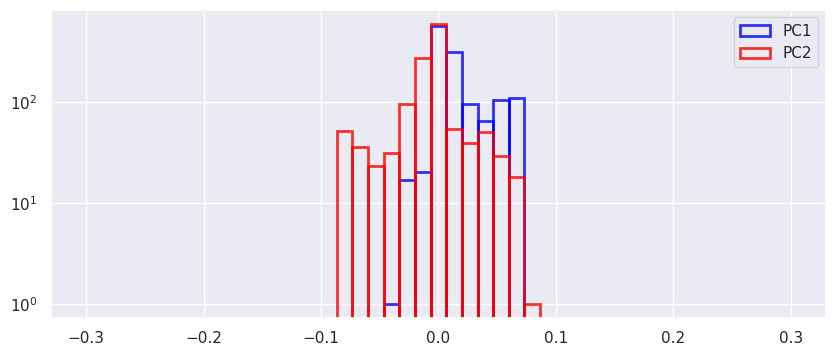

In [15]:
fig, ax = plt.subplots(figsize=(10,4))
colors = ["blue", "red", "green"]

for idx in range(0,2):
    ax.hist(TB[idx], bins=45, range=[-0.3,0.3], ec=colors[idx],  
            color=colors[idx], fc="none", alpha=0.8, label=f"PC{idx+1}", linewidth=2);
    ax.set(yscale='log')
    ax.legend()



#plt.savefig('/home/isabel/Documents/Doktorarbeit_Mai2022/P5_Ngo_fromSciebo/RNA/2022March_Run4/1_Analysis1_naiv/2a_PreAnalysis_woMM/plot_from_python/PC1_PC2_hist.svg')


In [16]:
# get the eigenvectors whith the highest entries 
idx_outliers_PC1 = np.argsort(np.abs(TB[0]))[::-1][0:100]
gen_outliers_PC1 = geneNames_filt[idx_outliers_PC1]
print(TB[0][idx_outliers_PC1])
print(gen_outliers_PC1)
print(idx_outliers_PC1)

idx_outliers_PC2 = np.argsort(np.abs(TB[1]))[::-1][0:100]
gen_outliers_PC2 = geneNames_filt[idx_outliers_PC2]
#print(TB[1][idx_outliers_PC2])
#print(idx_outliers_PC2)

[0.07253618 0.07156849 0.07112529 0.07101878 0.06977501 0.06948607
 0.06887031 0.06865957 0.06865844 0.06854284 0.06801142 0.06791618
 0.06783708 0.06782136 0.06778061 0.06752766 0.06742648 0.06737863
 0.06664128 0.06655205 0.06653426 0.06640163 0.0662994  0.06609244
 0.06593792 0.06591748 0.06577404 0.06573261 0.06569312 0.06545156
 0.06542018 0.06541278 0.06540022 0.06538414 0.06528141 0.06523065
 0.06497146 0.06474677 0.06469449 0.0646823  0.06459731 0.06449457
 0.06423681 0.06411025 0.06402543 0.06393939 0.06386528 0.06367191
 0.06338743 0.06334881 0.06333828 0.06326281 0.06316091 0.06314195
 0.06309495 0.06307545 0.06298517 0.0629767  0.06272937 0.06272757
 0.06264463 0.06262473 0.06248756 0.06243725 0.06242429 0.06240763
 0.06231188 0.06222255 0.06196434 0.06191389 0.06188724 0.06175434
 0.06169445 0.0616015  0.06155776 0.06154874 0.06140446 0.06138368
 0.06136906 0.06136508 0.06134751 0.06131122 0.06131118 0.06128721
 0.06126819 0.0611982  0.06114772 0.06114189 0.06103695 0.0610

In [17]:
# find the genes that are beyond the 95% part of the distribution
box      = np.zeros([2,2]);

outlier_sortAbs= [];
outlier_idx    = [];
for i in range(0,2):
    box[i]  = [np.mean(TB[i]) - 2*np.std(TB[i]),np.mean(TB[i]) + 2*np.std(TB[i])]
    outlier_bool = [np.logical_or(TB[i] > box[i][1],TB[i] < box[i][0])]
    #outlier_idx  = outlier_bool.nonzero()
    #outlier_value= TB[i][outlier_bool]
    #outlierVal = TB[i][outlier]
    #outlier_sortAbs.append(np.argsort(np.abs(outlier[i])))
    #outlier_idx.append(np.where(outlier_sortAbs[i]))
A = np.array([[1,2,3,4,5],[6,2,7,3,8],[6,2,7,3,8]])
AA = (A > 3).nonzero()
    #print(outlier_bool.nonzero())
#print([np.mean(TB[0]) - 2*np.std(TB[0]),np.mean(TB[0]) + 2*np.std(TB[0])])
AA

(array([0, 0, 1, 1, 1, 2, 2, 2]), array([3, 4, 0, 2, 4, 0, 2, 4]))

In [18]:
# do some small analysis with the genes that fall out here:
# 1. do PC1 and PC2 overlap?

np.intersect1d(gen_outliers_PC1,gen_outliers_PC2)

array([], dtype='<U32')


# Do it with a built-in function!!


In [19]:
shifted_raw[0:100,:].T.shape

(93, 100)

In [20]:

pca = PCA(n_components=4)
pca.fit(shifted_raw[100:300,:].T)
PCA(n_components=4)
print(pca.explained_variance_ratio_)
#print(pca.components_)
#eigen_val / np.sum(eigen_val)
pca.explained_variance_ratio_[0]
shifted_raw.T.shape

NameError: name 'PCA' is not defined

In [ ]:
dat_pca = pca.transform(shifted_raw[100:300,:].T)
# plot_two_PCs(dat_pca.T, [0, 1], pca.explained_variance_ratio_)
plt.scatter(dat_pca[:, 0], dat_pca[:, 1],color=color_cond)
plt.axis('equal');
plt.xlabel("PC1, variance makes up ~" + str(round(pca.explained_variance_ratio_[0]*100)) + "%")
plt.ylabel("PC1, variance makes up ~" + str(round(pca.explained_variance_ratio_[1]*100)) +  "%")


In [ ]:
np.array(15*["k"]+ 5 * ["gray"]+ 5* ["yellow"]+ 5* ["blue"]+ 5* ["red"])